## Bloomblerg Japan Hackathon 2018/09/01

The goal is to predict cryptocurrency price in the future. If possible, predict the timing to buy and sell.
Our team decided to use ensemble of different models, semantic text for hype in twitter discussion, technical analysis of historical price and influencse of other finacial markets like stock market and gold market, etc.

This notebook tries to implement the last idea, uses recent Bitcoin price, trade volume, NASDAQ index, OIL ETF index, GOLD ETF index and companies like BLK and BTCS as inputs to predict the BTC/USD price of the next day, given limited amount of time in this hackathon. Of course, the model can be extended to include more factors.

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

/Users/sushi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Get data from 2017/01/01 to 2017/11/09
Our team want to use data from 2017/09/01 to 2017/11/09 as testing data.

In [2]:
import glob
files = glob.glob("findex_data/*.csv")
print(files)
flie_list = []
for f in files:
    _df = pd.read_csv(f, header=0)
    flie_list.append(_df[['Open','Volume']])
df = pd.concat(flie_list, axis=1, sort=False)
index_names = ['BTC','BTC_V','BTCS','BTCS_V','NASDAQ','NASDAQ_V','OIL','OIL_V','GOLD','GOLD_V','BLK','BLK_V']
df.columns= index_names
df.head()

['findex_data/B.csv', 'findex_data/BTCS.csv', 'findex_data/NASDAQ.csv', 'findex_data/OILETF.csv', 'findex_data/GOLDETF.csv', 'findex_data/BLK.csv']


,BTC,BTC_V,BTCS,BTCS_V,NASDAQ,NASDAQ_V,OIL,OIL_V,GOLD,GOLD_V,BLK,BLK_V
0,1017.049988,56085870,0.12,119193200,5425.620117,1886200000,8.94,14900,8.11,162300,384.619995,743900
1,1033.300049,170584623,0.24,77647900,5440.910156,1883360000,8.46,5100,8.64,155200,384.649994,680800
2,1135.410034,244839289,0.24,27760600,5474.390137,1792610000,8.85,9100,8.74,285100,384.980011,468400
3,989.349976,179160668,0.18,20267000,5499.080078,1710770000,8.98,12600,8.96,239800,383.570007,453400
4,900.859985,55963281,0.18,9168200,5527.580078,1885500000,8.94,4700,9.01,371300,384.350006,505300


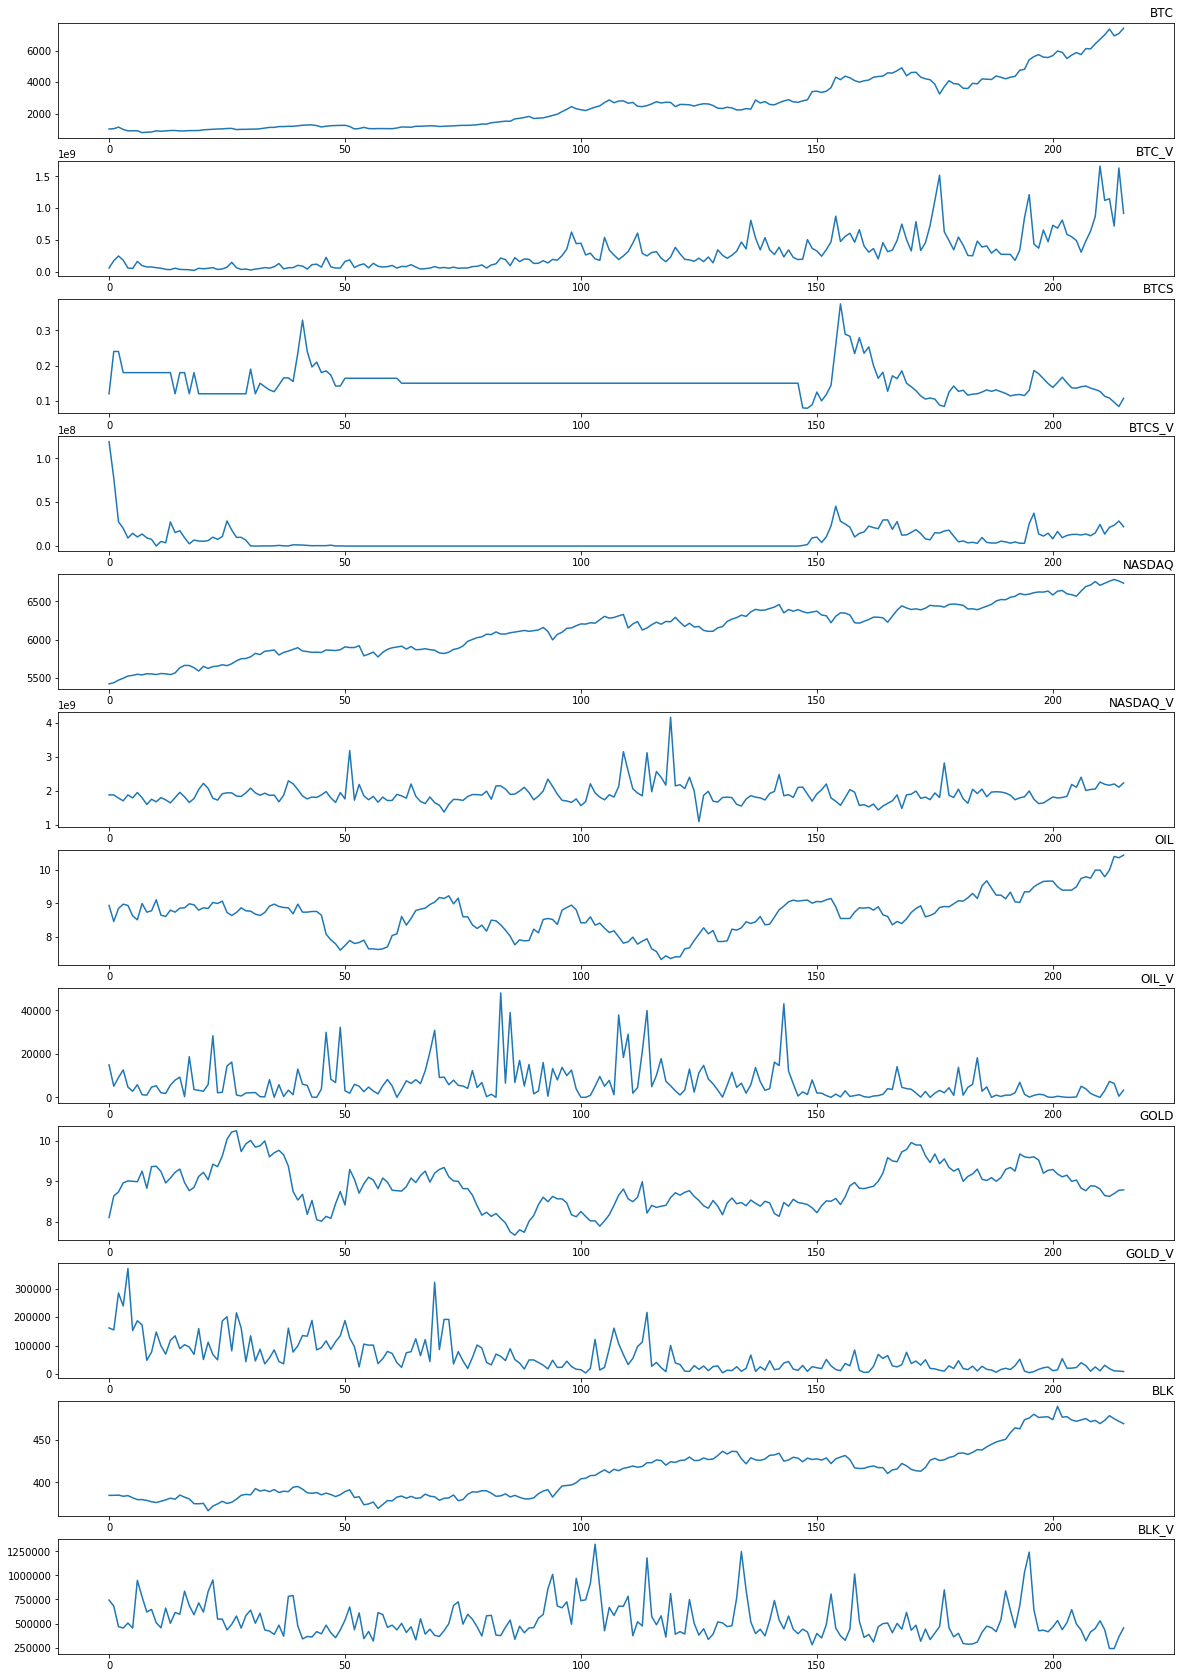

In [3]:
number_of_features = 12
plt.figure(figsize=(20,30))
for i in range(0, number_of_features):
    plt.subplot(number_of_features, 1, i+1)
    plt.plot(df.values[:, i])
    plt.title(df.columns[i], loc='right')
plt.show()

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
scaled_df = pd.DataFrame(scaled, columns=index_names)
scaled_df.head()

,BTC,BTC_V,BTCS,BTCS_V,NASDAQ,NASDAQ_V,OIL,OIL_V,GOLD,GOLD_V,BLK,BLK_V
0,0.034783,0.023385,0.138514,1.000000,0.000000,0.257144,0.517572,0.310417,0.167969,0.431138,0.147316,0.464612
1,0.037224,0.092965,0.543919,0.651446,0.011244,0.256216,0.364217,0.106250,0.375000,0.411813,0.147559,0.406386
2,0.052558,0.138089,0.543919,0.232904,0.035865,0.226551,0.488818,0.189583,0.414062,0.765378,0.150235,0.210390
3,0.030624,0.098177,0.341216,0.170035,0.054022,0.199798,0.530351,0.262500,0.500000,0.642079,0.138803,0.196549
4,0.017335,0.023311,0.341216,0.076919,0.074980,0.256915,0.517572,0.097917,0.519531,1.000000,0.145127,0.244440


In [5]:
#goal: use previous 10 steps to predict a new step
number_of_steps = 10
stepped_df_list = [scaled_df,]
for i in range(1, number_of_steps+1):
    one_step_df = scaled_df.shift(-i)
    one_step_df.columns = ["{}+{}d".format(x, i) for x in scaled_df.columns]
    stepped_df_list.append(one_step_df)
stepped_df = pd.concat(stepped_df_list, axis=1)
#drop first number_of_steps of rows
stepped_df = stepped_df.iloc[:-number_of_steps, :]
stepped_df.head()

,BTC,BTC_V,BTCS,BTCS_V,NASDAQ,NASDAQ_V,OIL,OIL_V,GOLD,GOLD_V,...,BTCS+10d,BTCS_V+10d,NASDAQ+10d,NASDAQ_V+10d,OIL+10d,OIL_V+10d,GOLD+10d,GOLD_V+10d,BLK+10d,BLK_V+10d
0,0.034783,0.023385,0.138514,1.000000,0.000000,0.257144,0.517572,0.310417,0.167969,0.431138,...,0.341216,0.000680,0.089218,0.190825,0.571885,0.110417,0.660156,0.392216,0.078725,0.247393
1,0.037224,0.092965,0.543919,0.651446,0.011244,0.256216,0.364217,0.106250,0.375000,0.411813,...,0.341216,0.044423,0.099270,0.230833,0.424920,0.043750,0.609375,0.259662,0.090968,0.199040
2,0.052558,0.138089,0.543919,0.232904,0.035865,0.226551,0.488818,0.189583,0.414062,0.765378,...,0.341216,0.031503,0.096520,0.209458,0.412141,0.037500,0.500000,0.180185,0.104021,0.388023
3,0.030624,0.098177,0.341216,0.170035,0.054022,0.199798,0.530351,0.262500,0.500000,0.642079,...,0.341216,0.230885,0.088997,0.180028,0.472843,0.116667,0.546875,0.312466,0.120723,0.242133
4,0.017335,0.023311,0.341216,0.076919,0.074980,0.256915,0.517572,0.097917,0.519531,1.000000,...,0.138514,0.129261,0.104904,0.230722,0.453674,0.164583,0.601562,0.356015,0.110670,0.345760


In [6]:
#train test split
#train period 2017/01/01 to 2017/08/31, data length = 168
#test period 2017/09/01 to 2017/11/10
number_training_rows = 168
values = stepped_df.values
train = values[:number_training_rows-number_of_steps, :]
test = values[number_training_rows-number_of_steps:, :]
train_X, train_y = train[:, :-number_of_features], train[:, -number_of_features]
test_X, test_y = test[:, :-number_of_features], test[:, -number_of_features]
# reshape to (samples, steps, features)
step_train_X = train_X.reshape((train_X.shape[0], number_of_steps, number_of_features))
step_test_X = test_X.reshape((test_X.shape[0], number_of_steps, number_of_features))
print(step_train_X.shape, train_y.shape, step_test_X.shape, test_y.shape)

(158, 10, 12) (158,) (48, 10, 12) (48,)


Train on 158 samples, validate on 48 samples
Epoch 1/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0807 - val_loss: 0.1526
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 0.1215 - val_loss: 0.2232
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0434 - val_loss: 0.1294
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.1453
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0391 - val_loss: 0.0907
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0677
Epoch 7/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0471
Epoch 8/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0213 - val_loss: 0.0445
Epoch 9/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0495
Epoch 10/100
158/158 [========================

Epoch 81/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0464
Epoch 82/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0194 - val_loss: 0.0448
Epoch 83/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0521
Epoch 84/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0202 - val_loss: 0.0418
Epoch 85/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0166 - val_loss: 0.0473
Epoch 86/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0514
Epoch 87/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0422
Epoch 88/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0432
Epoch 89/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0502
Epoch 90/100
158/158 [==============================] - 0s 1ms/step - loss: 0.0156

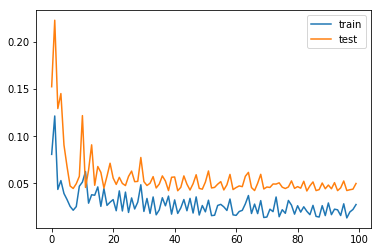

In [7]:
#LSTM model
model = Sequential()
model.add(LSTM(30, input_shape=(step_train_X.shape[1], step_train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(step_train_X, train_y, epochs=100, batch_size=10, validation_data=(step_test_X, test_y), shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
# predict
y_pred = model.predict(step_test_X)
# mean absolute error
print("Prediction MAE: {}".format(mean_absolute_error(test_y, y_pred)))

Prediction MAE: 0.04974872756948743


In [9]:
# compare with original price
btc_df = pd.read_csv('findex_data/B.csv', usecols=['Date', 'Open'])
pred_df = pd.DataFrame(btc_df.values[number_training_rows:,:])
pred_df.columns = ['Date', 'Actual Price']
def inverse_scale(y):
    y = np.concatenate((y, test_X[:, -(number_of_features-1):]), axis=1)
    y = scaler.inverse_transform(y)
    return y[:,0]
# inverse back to original prices
iy_pred = inverse_scale(y_pred)
pred_df['Predict'] = iy_pred
pred_df

,Date,Actual Price,Predict
0,2017-09-01,4921.85,4499.584574
1,2017-09-05,4409.08,4549.458630
2,2017-09-06,4618.71,4325.915235
3,2017-09-07,4635.6,4324.118851
4,2017-09-08,4326.45,4418.353581
5,2017-09-11,4217.9,4336.148589
6,2017-09-12,4158.92,4215.199498
7,2017-09-13,3870.29,4219.634891
8,2017-09-14,3243.08,4233.623345
9,2017-09-15,3713.76,4117.562911


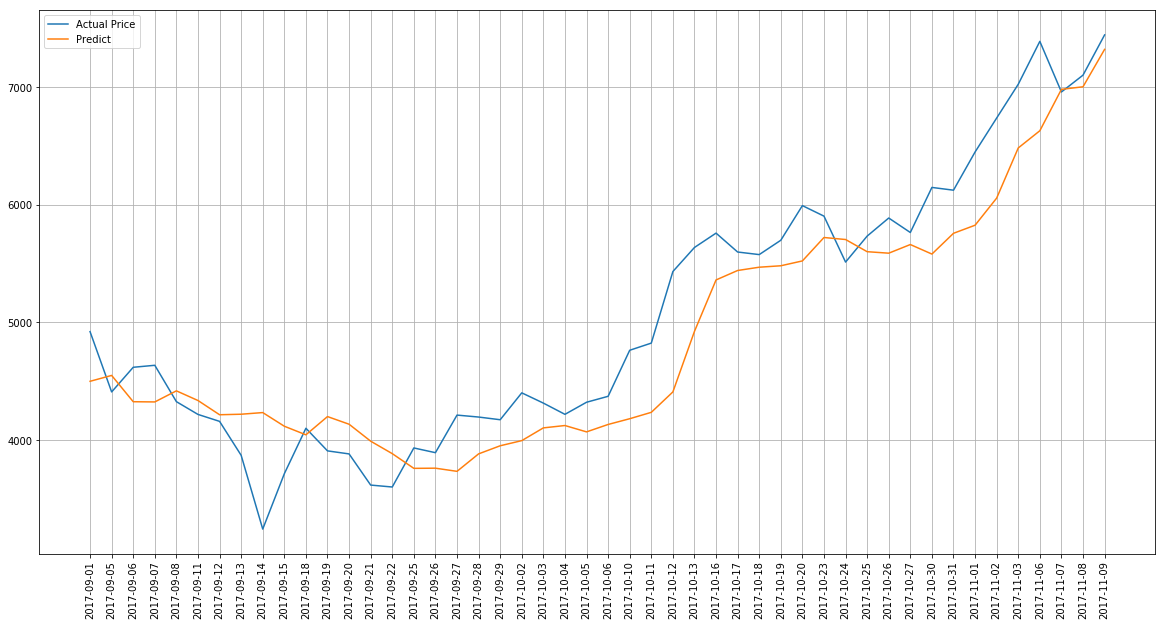

In [10]:
ax = pred_df.plot(xticks=pred_df.index, y=['Actual Price', 'Predict'], figsize=(20,10), grid=True)
ax.set_xticklabels(pred_df.Date, rotation=90)
plt.legend(loc='upper left')
plt.show()